Import all libraries. 

In [1]:
import numpy as np
import pandas as pd
import os
import nltk
import re
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from bs4 import BeautifulSoup
from nltk.stem.porter import PorterStemmer
from IPython.display import HTML
from pathlib import Path
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import nltk
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.metrics import accuracy_score

Define a function to read movie review text data into dataframe.

In [3]:
def read_data():
    datadir = "C:/Users/pingz/MLproject/movie_review/data/aclImdb/"
    flist_pos = [datadir + "/train/pos/" + e for e in os.listdir(datadir + "train/pos/") if e.endswith(".txt")]
    flist_neg = [datadir + "/train/neg/" + e for e in os.listdir(datadir + "train/neg/") if e.endswith(".txt")]

    review_pos=[]
    review_neg=[]
    for f in flist_pos:
        fo=open(f,encoding="utf8")
        review_pos.append(fo.readlines()[0])
        fo.close()

    for f in flist_neg:
        fo=open(f,encoding="utf8")
        review_neg.append(fo.readlines()[0])
        fo.close()
    train_data = pd.concat([pd.DataFrame({"review":review_pos, "label":1, "file":flist_pos}),\
        pd.DataFrame({"review":review_neg, "label":0, "file":flist_neg})], ignore_index=True).sample(frac=1, random_state=1)

    flist_pos = [datadir + "/test/pos/" + e for e in os.listdir(datadir + "test/pos/") if e.endswith(".txt")]
    flist_neg = [datadir + "/test/neg/" + e for e in os.listdir(datadir + "test/neg/") if e.endswith(".txt")]

    review_pos=[]
    review_neg=[]
    for f in flist_pos:
        fo=open(f,encoding="utf8")
        review_pos.append(fo.readlines()[0])
        fo.close()

    for f in flist_neg:
        fo=open(f,encoding="utf8")
        review_neg.append(fo.readlines()[0])
        fo.close()
    test_data = pd.concat([pd.DataFrame({"review":review_pos, "label":1, "file":flist_pos}),\
        pd.DataFrame({"review":review_neg, "label":0, "file":flist_neg})], ignore_index=True).sample(frac=1, random_state=1)

    return train_data,test_data

In [4]:
train_data,test_data=read_data() #read train and test data into dataframe. Positive reviews are marked as 1, and negative 0.

In [5]:
print(Counter(train_data['label']))
train_data.head()

Counter({0: 12500, 1: 12500})


,review,label,file
21492,"I have copy of this on VHS, I think they (The ...",0,C:/Users/pingz/MLproject/movie_review/data/acl...
9488,After several extremely well ratings to the po...,1,C:/Users/pingz/MLproject/movie_review/data/acl...
16933,I still don't know why I forced myself to sit ...,0,C:/Users/pingz/MLproject/movie_review/data/acl...
12604,Mt little sister and I are self-proclaimed hor...,0,C:/Users/pingz/MLproject/movie_review/data/acl...
8222,I have personally seen many Disney movies in m...,1,C:/Users/pingz/MLproject/movie_review/data/acl...


The training data is balanced since there are 12500 cases of negative reviews and 12500 cases of positive reviews. Therefore, we can use accuracy to evaluate the model's performance. 

In [6]:
print('Positive review: '+train_data['review'].iloc[1]+'\n')
print('Negative review: '+train_data['review'].iloc[0]) #check two examples of positive and negative reviews. 

Positive review: After several extremely well ratings to the point of SUPERB, I was extremely pleased with the film. The film was dark, moving, the anger, the pain, the guilt and a very extremely convincing demon.<br /><br />I had initially expected to see many special effects, and like a lover's caress, it blew me away with the subtlety and the rightness of it. Brian, I am again blown away with your artistry with the telling of the story and your care of the special effects. You will go a long way, my friend. I will definitely be the president of your fan club.<br /><br />Eric Etebari, the best actor award, was the number one choice. You made Jr. Lopez look like a child compared to Kasadya. :) <br /><br />Overall, the acting, story line, the high quality filming and awesome effects, it was fantastic. I just wish it were longer. I am looking forward to The Dreamless with extremely high expectations.

Negative review: I have copy of this on VHS, I think they (The television networks) sh

Remove HTML codes, replace special characters with space, conver to lower case

In [7]:
train_data['review'] = train_data['review'].apply(lambda r: BeautifulSoup(r, 'html.parser').get_text())
train_data['review'].replace(to_replace ='[^a-z A-Z]', value = '', regex = True, inplace = True)
train_data['review'] = train_data['review'].str.lower()  #convert to lower case

 Remove stopwords, duplicate words and grouping together the different forms of a word.

In [8]:
lemmatizer = WordNetLemmatizer()
nltk.download('stopwords')
estopwords = set(stopwords.words('english')).union(["thats","weve","dont","lets","youre","im","thi","ha",\
    "wa","st","ask","want","like","thank","know","susan","ryan","say","got","ought","ive","theyre"])  #get the English stop words
train_data['review'] = train_data['review'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in set(x.split()) if word not in estopwords]))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pingz\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Tokenize the words and pad the tokens with fixed length.

In [10]:
MAX_VOCABS = 5000
tokenizer = Tokenizer(num_words = MAX_VOCABS)
tokenizer.fit_on_texts(pd.concat([train_data['review']]))
x_train = tokenizer.texts_to_sequences(train_data['review'])
MAX_LEN = max([len(i) for i in x_train])
vocab_size = MAX_VOCABS + 1
x_train = pad_sequences(x_train, padding='post', maxlen=MAX_LEN, value=vocab_size)

Split train data into train data and validation data. 

In [11]:
y_train=np.array(train_data['label'])
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2, random_state = 42)

Train the model with embedd_dim=16.

In [12]:
embedd_dim = 16
model = keras.Sequential([keras.layers.Embedding(vocab_size + 1, embedd_dim), keras.layers.GlobalAveragePooling1D(),\
                          keras.layers.Dense(16, activation='relu'), keras.layers.Dense(1, activation='sigmoid')])
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
history = model.fit(x_train, y_train, epochs=75,  batch_size=512, verbose = 2, validation_data = (x_val, y_val))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 20000 samples, validate on 5000 samples
Epoch 1/75
20000/20000 - 1s - loss: 0.6928 - acc: 0.5289 - val_loss: 0.6922 - val_acc: 0.5002
Epoch 2/75
20000/20000 - 1s - loss: 0.6908 - acc: 0.5705 - val_loss: 0.6892 - val_acc: 0.5112
Epoch 3/75
20000/20000 - 1s - loss: 0.6857 - acc: 0.6731 - val_loss: 0.6815 - val_acc: 0.7340
Epoch 4/75
20000/20000 - 1s - loss: 0.6741 - acc: 0.7949 - val_loss: 0.6663 - val_acc: 0.8002
Epoch 5/75
20000/20000 - 1s - loss: 0.6529 - acc: 0.8055 - val_loss: 0.6409 - val_acc: 0.7702
Epoch 6/75
20000/20000 - 1s - loss: 0.6212 - acc: 0.8135 - val_loss: 0.6062 - val_acc: 0.8182
Epoch 7/75
20000/20000 - 1s - loss: 0.5805 - acc: 0.8364 - val_loss: 0.5669 - val_acc: 0.8060


Use the test data to test the performance of the data. 

In [15]:
test_data['review'] = test_data['review'].apply(lambda r: BeautifulSoup(r, 'html.parser').get_text())
test_data['review'].replace(to_replace ='[^a-z A-Z]', value = '', regex = True, inplace = True)
test_data['review'] = test_data['review'].str.lower()  #convert to lower case
test_data['review'] = test_data['review'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in set(x.split()) if word not in estopwords]))

x_test = tokenizer.texts_to_sequences(test_data['review'])
x_test = pad_sequences(x_test, padding='post', maxlen=MAX_LEN, value=vocab_size)
y_test=test_data['label']
y_test_predict_prob=model.predict(x_test)
y_test_predict=[1 if e >=0.5 else 0 for e in y_test_predict_prob]
print('accuracy score for test data with embedd_dim=16 is ',accuracy_score(y_test_predict,y_test))
df_test_label=pd.DataFrame({"test_label_true":list(y_test), "test_label_predict":y_test_predict,"test_label_predict_probability":list(y_test_predict_prob[:,0])})
df_test_label.to_csv('test_label_true_predict.csv',index=True)


accuracy score for test data with embedd_dim=16 is  0.86344


In [16]:
embedd_dim = 32
model32 = keras.Sequential([keras.layers.Embedding(vocab_size + 1, embedd_dim), keras.layers.GlobalAveragePooling1D(),\
                          keras.layers.Dense(32, activation='relu'), keras.layers.Dense(1, activation='sigmoid')])

model32.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
history = model32.fit(x_train, y_train, epochs=75,  batch_size=512, verbose = 2, validation_data = (x_val, y_val))
y_test_predict_prob=model32.predict(x_test)
y_test_predict=[1 if e >=0.5 else 0 for e in y_test_predict_prob]


Train on 20000 samples, validate on 5000 samples
Epoch 1/75
20000/20000 - 1s - loss: 0.6928 - acc: 0.5283 - val_loss: 0.6922 - val_acc: 0.5006
Epoch 2/75
20000/20000 - 1s - loss: 0.6906 - acc: 0.5751 - val_loss: 0.6883 - val_acc: 0.8234
Epoch 3/75
20000/20000 - 1s - loss: 0.6835 - acc: 0.6953 - val_loss: 0.6769 - val_acc: 0.8060
Epoch 4/75
20000/20000 - 1s - loss: 0.6642 - acc: 0.8030 - val_loss: 0.6489 - val_acc: 0.8150
Epoch 5/75
20000/20000 - 1s - loss: 0.6234 - acc: 0.8208 - val_loss: 0.5980 - val_acc: 0.8280
Epoch 6/75
20000/20000 - 1s - loss: 0.5601 - acc: 0.8304 - val_loss: 0.5309 - val_acc: 0.8356
Epoch 7/75
20000/20000 - 1s - loss: 0.4903 - acc: 0.8469 - val_loss: 0.4693 - val_acc: 0.8416
Epoch 8/75
20000/20000 - 1s - loss: 0.4338 - acc: 0.8489 - val_loss: 0.4283 - val_acc: 0.8462
Epoch 9/75
20000/20000 - 1s - loss: 0.3892 - acc: 0.8650 - val_loss: 0.3915 - val_acc: 0.8560
Epoch 10/75
20000/20000 - 1s - loss: 0.3552 - acc: 0.8712 - val_loss: 0.3674 - val_acc: 0.8602
Epoch 11/7

In [17]:
print('accuracy score for test data with embedd_dim=32 is ',accuracy_score(y_test_predict,y_test))

accuracy score for test data with embedd_dim=32 is  0.85388


In [33]:
history.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

It seems that when embedd_dim=16 is used, the model performance is better. 

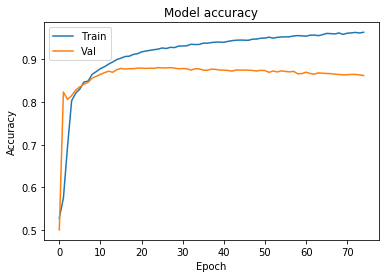

In [25]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

Although the accuracy for training set is increasing with Epoch, the accuracy for validation dataset starts to decrease after Epoch 18, and the model starts to overfit. 